# How covid-19 narratives are related to its propagation on social media?

**Author**: Muheng Yan

------------------------------------------------------------------------------------------------------------------------------

# Re-organizing RQs

Previously we have discovered the relationship between "actants' homophily"/"actants' LIWC scores" and the color coding/popularity.

Back to the general big RQ: "how stories are told and how it is affecting the cascade?", I re-organize the previous results into these three detailed RQs:


### RQ1: What are the story-tellings of the COVID-19 related articles, in terms of how story subjects are linked, how the subjects are used with specific linguistic cues (i.e. LIWC features), and how the subjects are forming well-known rumors?


### RQ2: How much the story-tellings of the COVID-19 articles are affecting their propagation in social media, in size and velocity?



# Decomposition of RQs

From the two RQs I take three lines of works:

### 1). What is the connectivity pattern for story subjects? How are they related to the propagation features? How are they evolving across weeks?

### 2). How are the subjects used with LIWC features? Relations to propagation? How evolved?

### 3). How the subjects are forming rumors? Relations to propagation? How evolved?


For each line I inspect the corresponding features and their relationship to propagation features. Previously I have shown results of the first two lines of features and their relationship to "propagation size" (audience size normalized popularity). In this node I will extend the results with: 1. weekly sliced results and 2. relationships with "propagation velocity"


# Data Involved

In this notebook I will use the processed articles of the first 6 weeks of our dataset: week 4, 5, 6, 7, 8, 9 of year 2020. The processing (parsing and relation extraction) for the full articles of month March and April is still ongoing. They will be later added when finished.

For each article I used the TITLE and FIRST SENTENCE as the base of investigations. Articles will only be shown partially (usually title and first sentence) in the embedded Tweets so that it would greatly reduce the noise when investigating their relationships with social media propagation features.

# A few Important Features and their Description

***Connectivity probabilities***: ratio of neighbors of a node belongs to the specific color. E.g. 0.1 of "green" in connectivity probability refers 10% of the node's neighbor are green nodes.

***Homophily***: ratio of neighbors of a node belongs to the "SAME" color. E.g. 0.1 of homophily for a red node indicates that 10% of its neighbors are red.

***LIWC features***: proportion of actants in a node appeared with the spicific LIWC features in a same sentence. E.g. node "man" consists of two actants of "man" appeared once with "negate", then the "negate" score for the node is 0.5.

***Popularity***: the average popularity scores ((#rt + #favorate)/(#followers + epsilon) per article) of articles  where any actants in a node appeared in.

***Lifespan***: the average lifespan of articles (last post date - first post date in hours) where any actants in a node appeared in.

***Halflife***: the average "hours an article get 50% shares" where any actants in a node appeared in.

***Velocity Ratio***: the average "halflife / lifespan" of areticles where any actants in a node appeared in.

In [2]:
#utils
import pandas as pd
import pickle

import numpy as np
import networkx as nx

from sklearn import preprocessing

import os

from tqdm import tqdm
from utils import *

import matplotlib.pyplot as plt
import matplotlib

import statsmodels.api as sm

import numpy as np
from scipy.stats import norm
from sklearn.linear_model import LogisticRegression

import copy

from sklearn.preprocessing import MinMaxScaler

COLORS = ['green', 'yellow', 'orange', 'red', 'black']
non_mix_COLORS = ['green', 'yellow', 'orange', 'red']
WEEKS = range(4, 19)

LIWC_KEYS = ['achieve', 'adverb', 'affect', 'anger', 'anx', 'article', 'assent', 
             'auxverb', 'bio', 'body', 'cause', 'certain', 'cogmech', 'conj', 'death', 
             'dic_wc', 'discrep', 'excl', 'family', 'feel', 'filler', 'friend', 
             'funct', 'future', 'health', 'hear', 'home', 'humans', 'i', 'incl', 
             'ingest', 'inhib', 'insight', 'ipron', 'leisure', 'money', 'motion', 
             'negate', 'negemo', 'nonfl', 'number', 'p1', 'p2', 'p3', 'past', 
             'percept', 'posemo', 'ppron', 'preps', 'present', 'pronoun', 'quant', 
             'relativ', 'relig', 'sad', 'see', 'sexual', 'shehe', 'social', 
             'space', 'swear', 'tentat', 'they', 'time', 'verb', 'wc', 'we', 'work', 'you']

features = [
    'name', 'week', 'color',
    'self_green', 'self_yellow', 'self_orange', 'self_red',
    'connect_green', 'connect_yellow', 'connect_orange', 'connect_red', 'connect_mix',
    'homophily', 'freq', 'degree'
]

features += LIWC_KEYS
features += ['pop', 'rt', 'fav', 'lifespan', 'halflife', 'velocity_ratio']

def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])


# Basic stats of per-week graphs
This is the volumns of #articles/nodes per week from last week's results

In [ ]:
# img = plt.imread('graph_stats.png')
# plt.figure(figsize=(200, 150))
# fig = plt.imshow(img)
# plt.axis('off')
# plt.show()

In [3]:
#agg dataset of nodes by weeks
weeks = WEEKS
overwrite = False

if not overwrite and os.path.exists('data/cache/weekly_nodes_df.pkl'):
    weekly_nodes_df = pickle.load(open('data/cache/weekly_nodes_df.pkl', 'rb'))

else:
    weekly_nodes_df = pd.DataFrame(columns=features)

    for week in weeks:
        G, GD, nodes_in_graph, und_edges_in_graph, dir_edges_in_graph = pickle.load(open(f'output/graph_title+1s_week_{week}.pkl', 'rb'))
        node_list = list(G.nodes())
        

        _baseline_colors = np.zeros(5)
        for nd in node_list:
            color = take_node_color(nodes_in_graph[nd]['norm_color'])
            _baseline_colors[COLORS.index(color)] += 1

        _baseline_colors = _baseline_colors / np.sum(_baseline_colors)

        for nd in tqdm(node_list):
            
            row = []
            node_name = nd

            nbs = G.neighbors(nd)
            connected = np.zeros(5)

            self_color = take_node_color(nodes_in_graph[nd]['norm_color'])

            for nb in nbs:    
                _nbc = take_node_color(nodes_in_graph[nb]['norm_color'])
                connected[COLORS.index(_nbc)] += 1


            connected = connected / np.sum(connected)
            norm_connected = connected/_baseline_colors            

            norm_connected = norm_connected / np.sum(norm_connected) # vec
            self_color_prob = nodes_in_graph[nd]['color'] # vec
            homophily = norm_connected[COLORS.index(self_color)] #scalar

            LIWCs = nodes_in_graph[nd]['LIWC']

            pop = nodes_in_graph[nd]['pop']
            rt = nodes_in_graph[nd]['rt']
            fav = nodes_in_graph[nd]['fav']
            freq = nodes_in_graph[nd]['freq']

            vel_life = nodes_in_graph[nd]['vel_life']
            vel_mid = nodes_in_graph[nd]['vel_mid']
            vel_ratio = nodes_in_graph[nd]['vel_ratio']


            row = [node_name, week, COLORS.index(self_color)]
            row += list(self_color_prob)
            row += list(norm_connected)
            row.append(homophily)
            row.append(freq)
            row.append(G.degree(nd))
            row += list(LIWCs)
            row += [pop, rt, fav, vel_life, vel_mid, vel_ratio]


            row = pd.Series(row, index = all_nodes_df.columns)
            weekly_nodes_df = weekly_nodes_df.append(row, ignore_index=True)
            
    
    pickle.dump(weekly_nodes_df, open('data/cache/weekly_nodes_df.pkl', 'wb'))

In [4]:
#dataset of nodes across weeks

overwrite = False
if not overwrite and os.path.exists('data/cache/all_nodes_df.pkl'):
    all_nodes_df = pickle.load(open('data/cache/all_nodes_df.pkl', 'rb'))

else:
    all_nodes_df = pd.DataFrame(columns=features)

    G, GD, nodes_in_graph, und_edges_in_graph, dir_edges_in_graph = pickle.load(open(f'output/graph_title+1s_all_nodes_merged.pkl', 'rb'))
    node_list = list(G.nodes())
    

    _baseline_colors = np.zeros(5)
    for nd in node_list:
        color = take_node_color(nodes_in_graph[nd]['norm_color'])
        _baseline_colors[COLORS.index(color)] += 1

    _baseline_colors = _baseline_colors / np.sum(_baseline_colors)

    for nd in tqdm(node_list):

        row = []
        node_name = nd

        nbs = G.neighbors(nd)
        connected = np.zeros(5)

        self_color = take_node_color(nodes_in_graph[nd]['norm_color'])

        for nb in nbs:    
            _nbc = take_node_color(nodes_in_graph[nb]['norm_color'])
            connected[COLORS.index(_nbc)] += 1


        connected = connected / np.sum(connected)
        norm_connected = connected/_baseline_colors            

        norm_connected = norm_connected / np.sum(norm_connected) # vec
        self_color_prob = nodes_in_graph[nd]['color'] # vec
        homophily = norm_connected[COLORS.index(self_color)] #scalar

        LIWCs = nodes_in_graph[nd]['LIWC']

        pop = nodes_in_graph[nd]['pop']
        rt = nodes_in_graph[nd]['rt']
        fav = nodes_in_graph[nd]['fav']
        freq = nodes_in_graph[nd]['freq']

        vel_life = nodes_in_graph[nd]['vel_life']
        vel_mid = nodes_in_graph[nd]['vel_mid']
        vel_ratio = nodes_in_graph[nd]['vel_ratio']


        row = [node_name, 'NA', COLORS.index(self_color)]
        row += list(self_color_prob)
        row += list(norm_connected)
        row.append(homophily)
        row.append(freq)
        row.append(G.degree(nd))
        row += list(LIWCs)
        row += [pop, rt, fav, vel_life, vel_mid, vel_ratio]


        row = pd.Series(row, index = all_nodes_df.columns)
        all_nodes_df = all_nodes_df.append(row, ignore_index=True)
            
    
    pickle.dump(all_nodes_df, open('data/cache/all_nodes_df.pkl', 'wb'))

In [5]:
weekly_nodes_df.head()

,name,week,color,self_green,self_yellow,self_orange,self_red,connect_green,connect_yellow,connect_orange,...,wc,we,work,you,pop,rt,fav,lifespan,halflife,velocity_ratio
0,SUPER:man|woman,4,4,0.185185,0.592593,0.000000,0.222222,0.056702,0.050480,0.000000,...,1.0,0.000000,0.065217,0.000000,0.003194,2.370370,2.592593,49.366389,8.767500,0.164886
1,dud,4,3,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,1.0,0.000000,0.000000,0.000000,0.015267,2.000000,2.000000,1626.524167,169.941944,0.104482
2,SUPER:centre|hub,4,1,0.166667,0.833333,0.000000,0.000000,0.089860,0.059999,0.000000,...,1.0,0.166667,0.500000,0.000000,0.001826,2.166667,3.000000,46.273472,5.196250,0.169575
3,heathrow,4,1,0.000000,1.000000,0.000000,0.000000,0.000000,0.197531,0.000000,...,1.0,0.000000,1.000000,0.000000,0.003086,2.000000,3.500000,4.312222,0.051111,0.505926
4,SUPER:uk_government|chinese_government|government,4,1,0.000000,0.833333,0.055556,0.111111,0.131224,0.262852,0.167504,...,1.0,0.111111,1.000000,0.037037,0.003411,6.833333,7.055556,49.125833,3.373333,0.095666


In [6]:
all_nodes_df.head()

,name,week,color,self_green,self_yellow,self_orange,self_red,connect_green,connect_yellow,connect_orange,...,wc,we,work,you,pop,rt,fav,lifespan,halflife,velocity_ratio
0,SUPER:people_wearing_face|one_man|man,NA,4,0.256972,0.587649,0.072709,0.082669,0.070421,0.126454,0.072399,...,1.0,0.034483,0.398220,0.018910,0.009831,5.562749,13.951195,6.811250,1.042083,0.984453
1,SUPER:breitbart_london|matt_hancock|tom_hank,NA,4,0.348837,0.449612,0.162791,0.038760,0.000000,0.000000,0.000000,...,1.0,0.070423,0.492958,0.004695,0.008446,11.542636,22.403101,1.155000,0.236944,1.000000
2,SUPER:oak_medical_centre|centre|central_bank,NA,4,0.308333,0.350000,0.291667,0.050000,0.029662,0.056303,0.129851,...,1.0,0.037736,0.603774,0.006289,0.006970,10.383333,23.275000,3.369028,0.813333,0.779567
3,SUPER:heathrow_airport|heathrow,NA,1,0.222222,0.703704,0.037037,0.037037,0.055167,0.078537,0.000000,...,1.0,0.000000,0.333333,0.000000,0.001838,1.222222,1.518519,8.624444,1.431389,0.910424
4,SUPER:uk_government|chinese_government|government,NA,4,0.387290,0.369305,0.154676,0.088729,0.088680,0.046590,0.110917,...,1.0,0.080106,0.998239,0.016725,0.003550,6.721823,13.488010,4.782083,1.054722,0.970077


In [7]:
#transform non-probability features (e.g. LIWC features) into normal distribution by quantiles. 
#This spreads the over centralized values (e.g. in popularity) and provide robustness against extreme outliers

# quantile_transformer = preprocessing.QuantileTransformer(n_quantiles=10000, output_distribution='normal', random_state=42)
# norm_data = quantile_transformer.fit_transform(all_nodes_df[all_nodes_df.columns[13:]]) #[13:] non-probability features
# all_nodes_df[all_nodes_df.columns[13:]] = norm_data


all_nodes_df = all_nodes_df[all_nodes_df['degree'] > 1] #nodes that at least connected to 2 other nodes
weekly_nodes_df = weekly_nodes_df[weekly_nodes_df['degree'] > 1] #nodes that at least connected to 2 other nodes

print(len(all_nodes_df))
print(len(weekly_nodes_df))

7199
20537


# Q1-1: What is the connectivity pattern for story subjects?

I plot the (1). the weekly changes of the connecting probability of a certain colored nodes to other colors, and (2). the weekly changes of the homophily of certain types of nodes.

** both connecting probability and homophily are normalized by natural distribution of colors.

From the plot I found that each types of nodes tends to connect to self-typres other than "mixed" nodes, connections to other colored nodes are always below 10%.

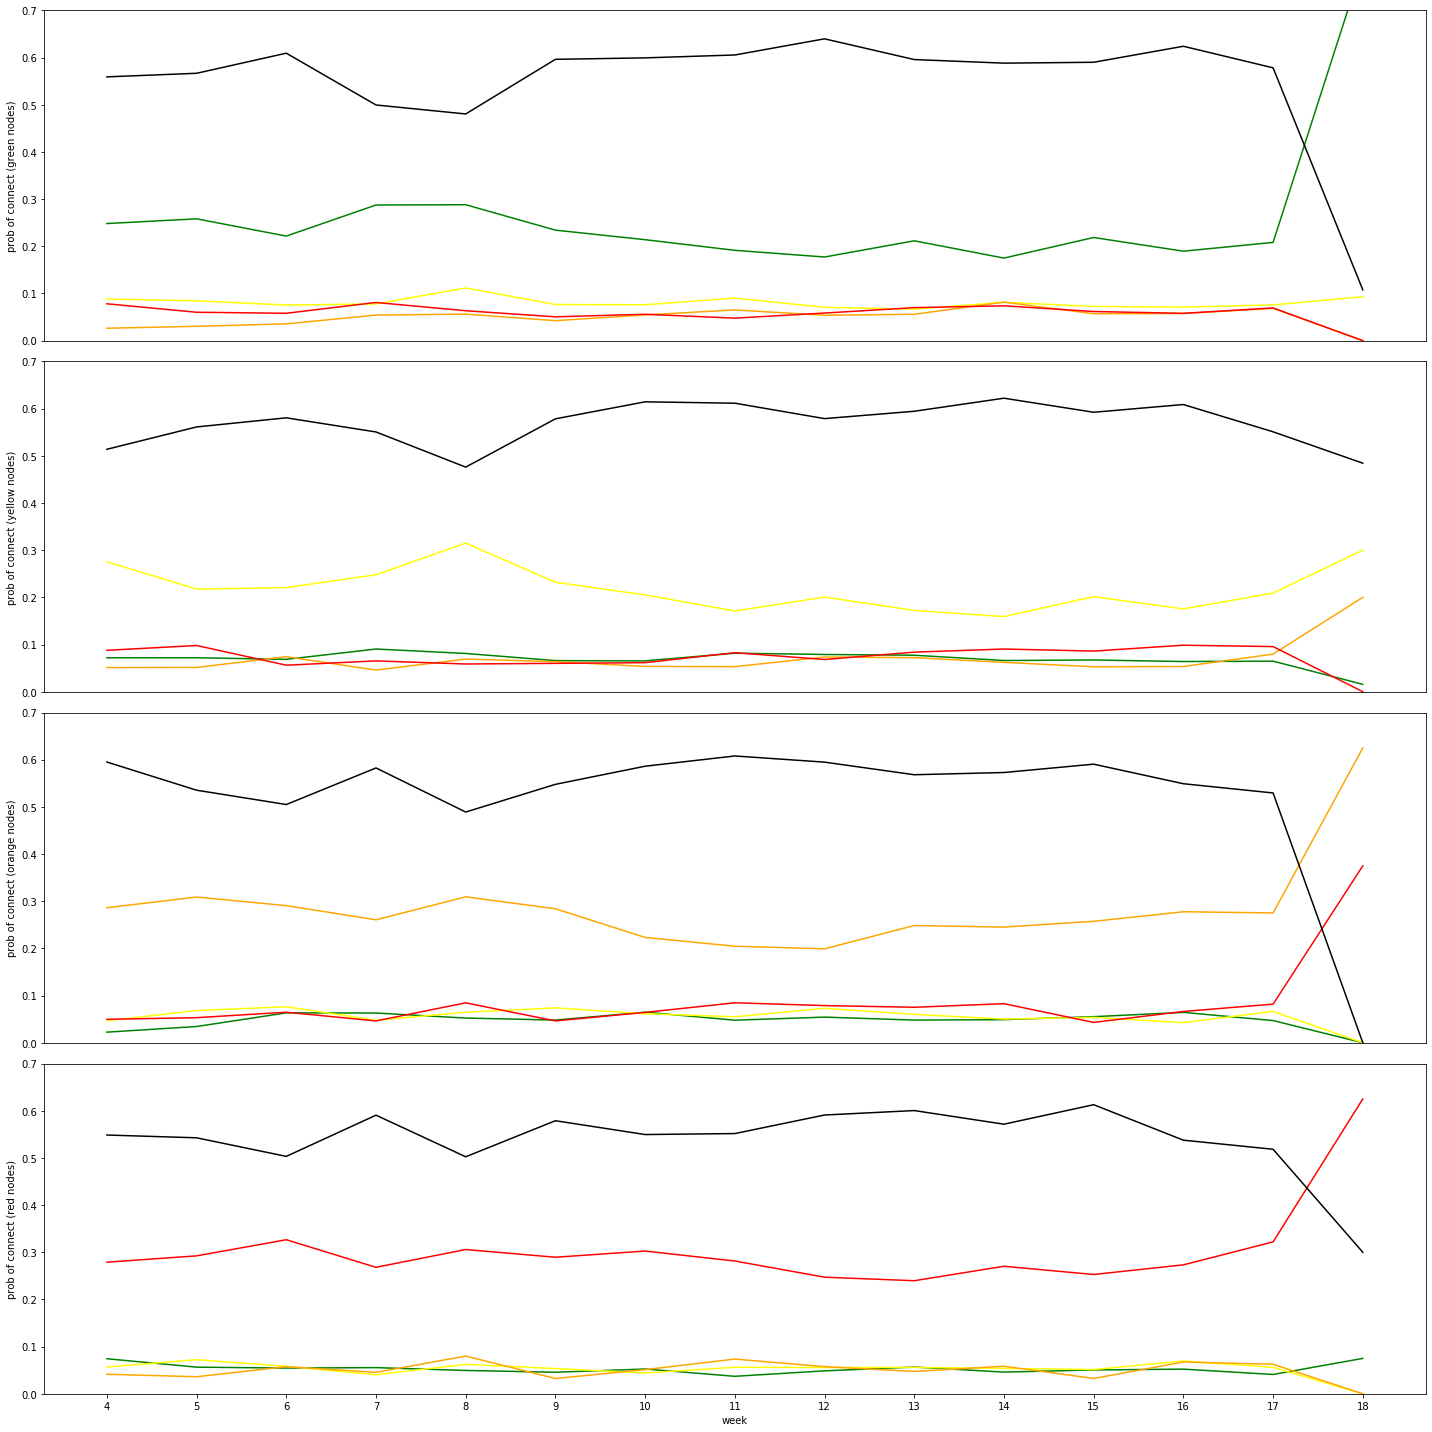

In [8]:
#weekly connectivity
color_connectivity = {}

for color in non_mix_COLORS:
    if color not in color_connectivity:
        color_connectivity[color] = {'connect': [], 'homophily': []}
        
        
    for week in WEEKS:
        _data = weekly_nodes_df[(weekly_nodes_df['color'] == COLORS.index(color)) & (weekly_nodes_df['week'] == week)]
        _connect = np.array([_data['connect_green'], _data['connect_yellow'], _data['connect_orange'], _data['connect_red'], _data['connect_mix']])
        _connect = np.mean(_connect, axis=1)
        
        _homophily = np.mean(_data['homophily'])
        
        color_connectivity[color]['connect'].append(_connect)
        color_connectivity[color]['homophily'].append(_homophily)
        
#plot weekly change of connectivity
fig, ax = plt.subplots(4, 1, figsize=(20, 20))

for i, color in enumerate(non_mix_COLORS):
    _connect_data = np.array(color_connectivity[color]['connect']).T # 5 by #week
    for j, connect_color in enumerate(COLORS):
        _plot_data = _connect_data[j]
        ax[i].plot(_plot_data, color=connect_color)
    ax[i].set_ylim(0.0, 0.7)
    ax[i].get_xaxis().set_visible(False)
    ax[i].set_ylabel(f'prob of connect ({color} nodes)')
        

ax[3].get_xaxis().set_visible(True)
ax[3].set_xticks(range(len(WEEKS)))
ax[3].set_xticklabels([f'{item:.0f}' for item in WEEKS])
ax[3].set_xlabel('week')

plt.tight_layout()
plt.show()


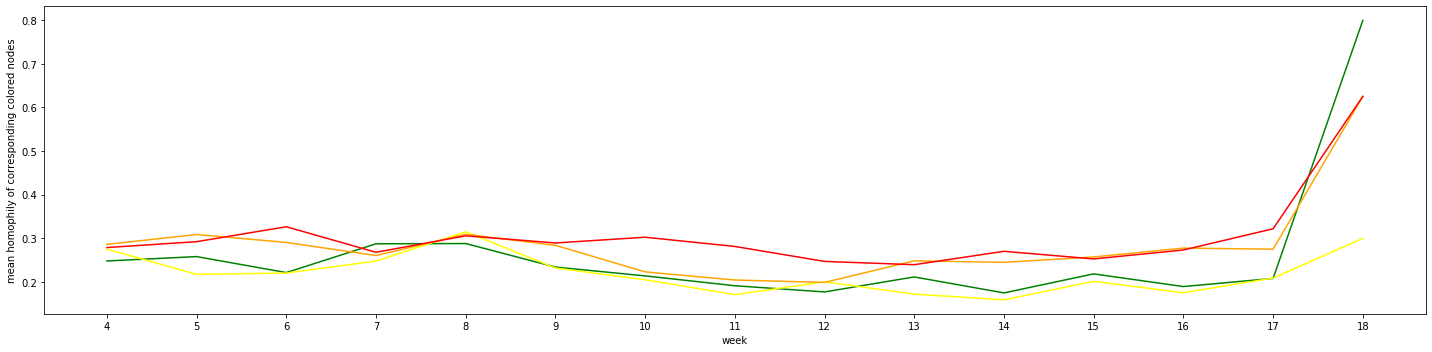

In [9]:
#homophily of colors
fig, ax = plt.subplots(1, 1, figsize=(20, 5))

for i, color in enumerate(non_mix_COLORS):
    
    perc25 = []
    perc50 = []
    perc75 = []
    mean = []
    for week in WEEKS:
        _homo_data = weekly_nodes_df[(weekly_nodes_df['color'] == COLORS.index(color)) & (weekly_nodes_df['week'] == week)]['homophily']
        _homo_25, _homo_50, _homo_75 = np.percentile(_homo_data, [25, 50, 75])
        perc25.append(_homo_25)
        perc50.append(_homo_50)
        perc75.append(_homo_75)
        mean.append(np.mean(_homo_data))
        
    
    ax.plot(mean, color=color)
    
#     ax.fill_between(perc25, perc75, alpha=0.9, facecolor='b')
#     ax[i].set_ylim(0.0, 0.7)
    ax.get_xaxis().set_visible(False)
    ax.set_ylabel(f'mean homophily of corresponding colored nodes')
        

ax.get_xaxis().set_visible(True)
ax.set_xticks(range(len(WEEKS)))
ax.set_xticklabels([f'{item:.0f}' for item in WEEKS])
ax.set_xlabel('week')

plt.tight_layout()
plt.show()


# Q1-2: How are they related to the propagation features? 

I plot the CDF of homophily of nodes grouped by color and high/low popularities. Figure 5 is the figure for all nodes and figure 6 is the overlayed figure of the first 4 figures.



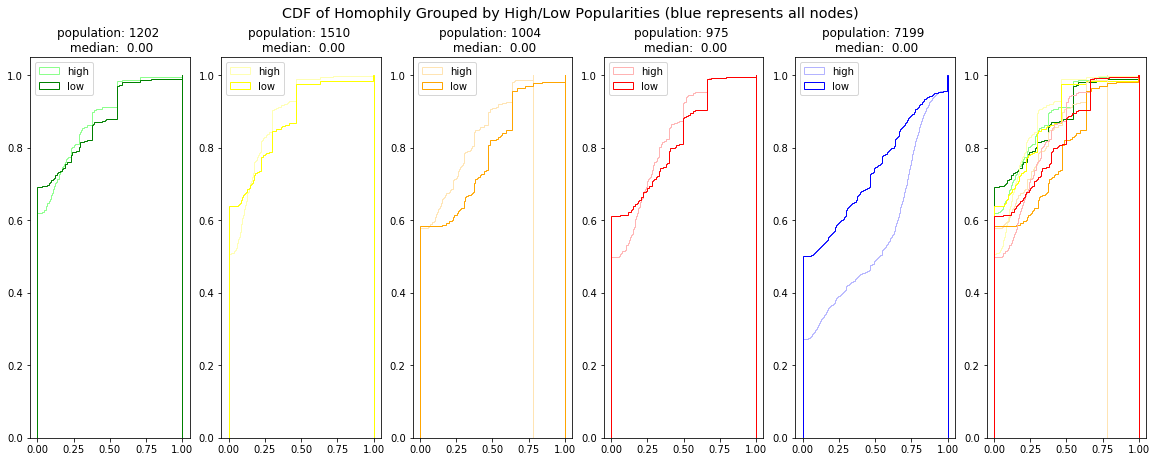

In [22]:
#homophily -> pop

cumulative = True

plot_df = all_nodes_df

fig, ax = plt.subplots(1, 6, figsize=(20, 7))

fig.suptitle("CDF of Homophily Grouped by High/Low Popularities (blue represents all nodes)", fontsize="x-large")

for i, color in enumerate(non_mix_COLORS):
    _color_data = plot_df[(plot_df['color'] == COLORS.index(color))]
    
    _pop = _color_data['pop']
    
    _high_data = _color_data[_color_data['pop'] >= np.median(_pop)]
    _low_data = _color_data[_color_data['pop'] < np.median(_pop)]
    
    ax[i].hist(_high_data['homophily'], color=lighten_color(color, 0.3), density=True, bins=400, cumulative=cumulative, histtype='step', label='high')
    ax[i].hist(_low_data['homophily'], color=lighten_color(color, 1.0), density=True, bins=400, cumulative=cumulative, histtype='step', label='low')
    
    
    ax[i].set_title(f'population: {len(_color_data)} \n median: {np.median(_pop): .2f}')
    
    ax[i].legend(loc='upper left')
    
    ax[5].hist(_high_data['homophily'], color=lighten_color(color, 0.3), density=True, bins=400, cumulative=cumulative, histtype='step', label='high')
    ax[5].hist(_low_data['homophily'], color=lighten_color(color, 1.0), density=True, bins=400, cumulative=cumulative, histtype='step', label='low')
    
    

_pop = plot_df['pop']
_high_data = plot_df[plot_df['pop'] >= np.median(_pop)]
_low_data = plot_df[plot_df['pop'] < np.median(_pop)]


ax[4].hist(_high_data['homophily'], color=lighten_color('blue', 0.3), density=True, bins=400, cumulative=True, histtype='step', label='high')
ax[4].hist(_low_data['homophily'], color=lighten_color('blue', 1.0), density=True, bins=400, cumulative=True, histtype='step', label='low')

ax[4].set_title(f'population: {len(plot_df)} \n median: {np.median(_pop): .2f}')
ax[4].legend(loc='upper left')


plt.show()

In general, red/orange nodes are having higher homophily than green/yellow. The relationship between homophily and popularity depends: when below certain thresholds (i.e. the crossing in the cdf curves), high pop nodes are having higher homophilies, but when above the threshold, the situation reverse.

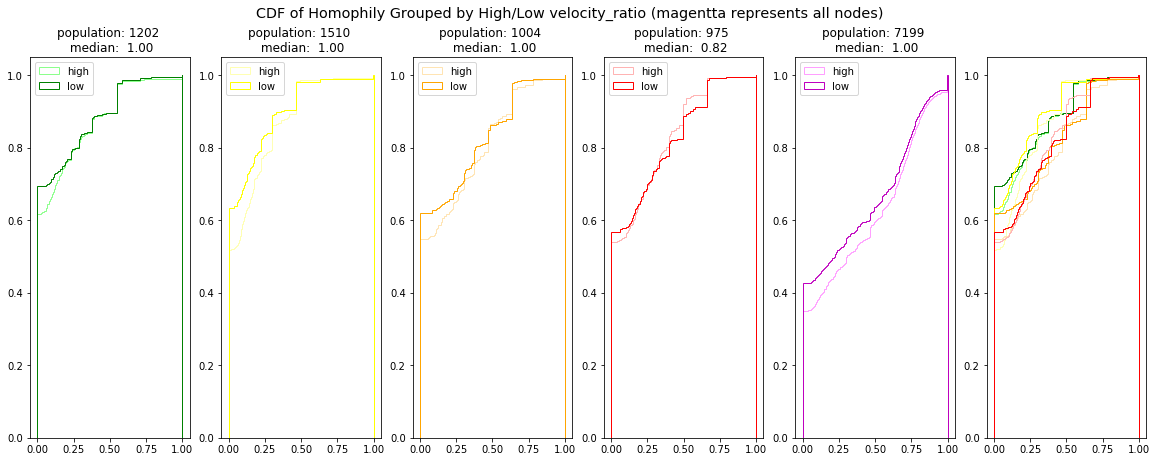

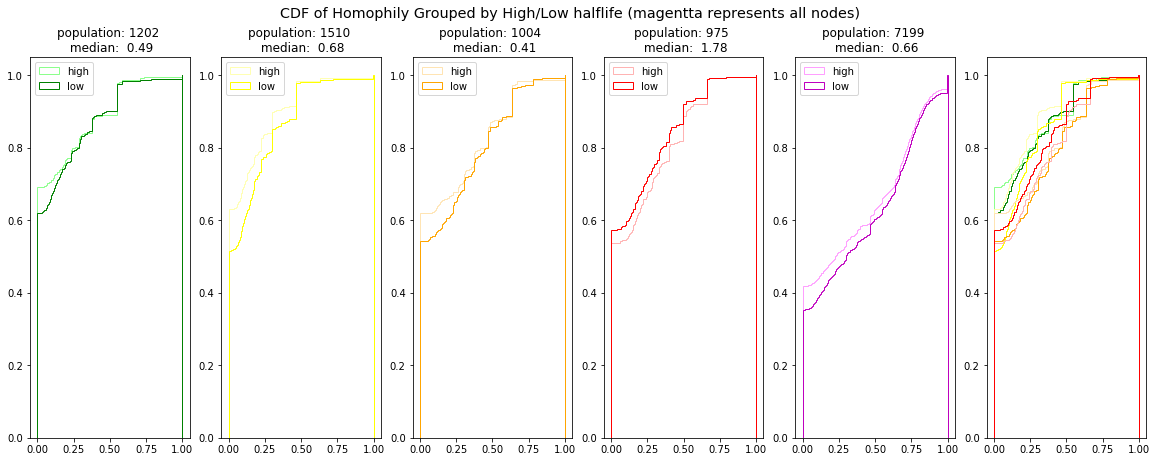

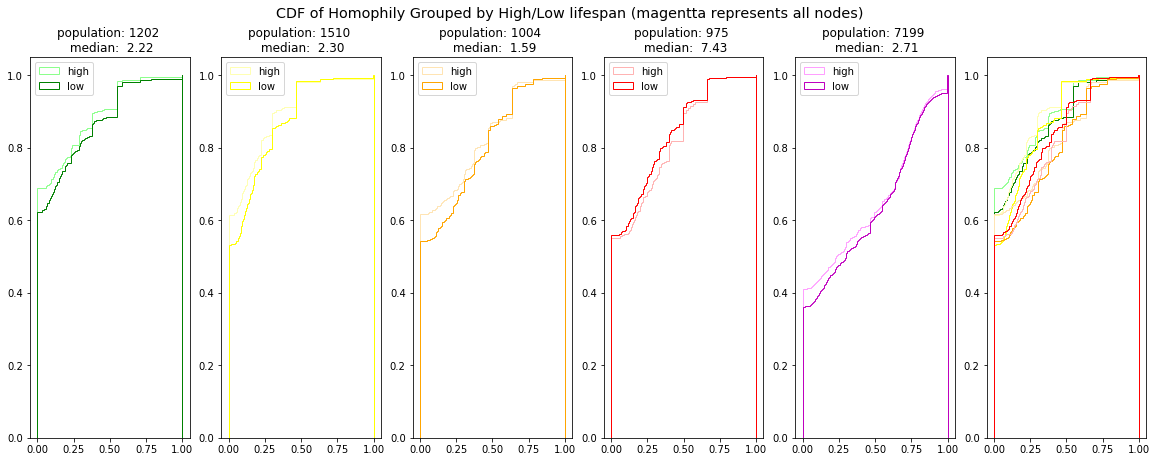

In [23]:
#homophily -> velocity

plot_df = all_nodes_df

cumulative = True



scale = lambda x:x
# scale = np.log10

for velocity in ['velocity_ratio', 'halflife', 'lifespan']:
    fig, ax = plt.subplots(1, 6, figsize=(20, 7))

    fig.suptitle(f"CDF of Homophily Grouped by High/Low {velocity} (magentta represents all nodes)", fontsize="x-large")

    for i, color in enumerate(non_mix_COLORS):
        _color_data = plot_df[(plot_df['color'] == COLORS.index(color))]

        _pop = _color_data[velocity]

        _high_data = _color_data[_color_data[velocity] >= np.median(_pop)]
        _low_data = _color_data[_color_data[velocity] < np.median(_pop)]

        ax[i].hist(scale(_high_data['homophily'] + 1e-7), color=lighten_color(color, 0.3), density=True, bins=400, cumulative=cumulative, histtype='step', label='high')
        ax[i].hist(scale(_low_data['homophily'] + 1e-7), color=lighten_color(color, 1.0), density=True, bins=400, cumulative=cumulative, histtype='step', label='low')

        ax[i].legend(loc='upper left')

        ax[i].set_title(f'population: {len(_color_data)} \n median: {np.median(_pop): .2f}')


        ax[5].hist(scale(_high_data['homophily'] + 1e-7), color=lighten_color(color, 0.3), density=True, bins=400, cumulative=cumulative, histtype='step', label='high')
        ax[5].hist(scale(_low_data['homophily'] + 1e-7), color=lighten_color(color, 1.0), density=True, bins=400, cumulative=cumulative, histtype='step', label='low')


    _pop = plot_df[velocity]
    _high_data = plot_df[plot_df[velocity] >= np.median(_pop)]
    _low_data = plot_df[plot_df[velocity] < np.median(_pop)]

    ax[4].hist(scale(_high_data['homophily'] + 1e-7), color=lighten_color('m', 0.3), density=True, bins=400, cumulative=True, histtype='step', label='high')
    ax[4].hist(scale(_low_data['homophily'] + 1e-7), color=lighten_color('m', 1.0), density=True, bins=400, cumulative=True, histtype='step', label='low')

    ax[4].set_title(f'population: {len(plot_df)} \n median: {np.median(_pop): .2f}')
    ax[4].legend(loc='upper left')


    plt.show()


As to the **propagation velocity (ratio)**, I have a similar figure arrangement as above.

In general, high-velocity-ratio nodes are having higher homophily, but it reverse when the measurement is lifetime (low-lifespan/halflife nodes are having higher homophily).

There are clear separations where red/orange nodes are having slower propagations.

# Q2-1: What are the important LIWC features that are informative to node popularity/velocity?

To answer this question I first select a few sense-making features and check their distributions over the groupings of color + popularity or color + velocity. Detailed notes can be found below each figure. 

In [12]:
#setup LIWC keys

LIWC_KEYS = ['achieve', 'adverb', 'affect', 'anger', 'anx', 'article', 'assent', 
             'auxverb', 'bio', 'body', 'cause', 'certain', 'cogmech', 'conj', 'death', 
             'dic_wc', 'discrep', 'excl', 'family', 'feel', 'filler', 'friend', 
             'funct', 'future', 'health', 'hear', 'home', 'humans', 'i', 'incl', 
             'ingest', 'inhib', 'insight', 'ipron', 'leisure', 'money', 'motion', 
             'negate', 'negemo', 'nonfl', 'number', 'p1', 'p2', 'p3', 'past', 
             'percept', 'posemo', 'ppron', 'preps', 'present', 'pronoun', 'quant', 
             'relativ', 'relig', 'sad', 'see', 'sexual', 'shehe', 'social', 
             'space', 'swear', 'tentat', 'they', 'time', 'verb', 'wc', 'we', 'work', 'you']

candidates = ['anger', 'anx', 'certain', 'death',  'family', 'feel', 
              'friend', 'health', 'hear', 'humans', 'money',  'negate', 
              'negemo', 'posemo',  'relig', 'sad', 'social',  'swear']

#LIWC over color

# fig, ax = plt.subplots(3, 6, figsize=(20, 10))

# fig.suptitle("LIWC - color codes", fontsize="x-large")


# for i, _feat in enumerate(candidates):
#     y = i % 6
#     x = int(i/6)
    
#     for color in non_mix_COLORS:
#         _data = all_nodes_df[all_nodes_df['color'] == COLORS.index(color)][_feat]
#         ax[x][y].hist(_data, color=color, density=True, bins=400, cumulative=cumulative, histtype='step')
    
#     ax[x][y].set_title(f'{_feat}')
    
# plt.show()

In [13]:
#LIWC over pop

# fig, ax = plt.subplots(3, 6, figsize=(20, 10))

# fig.suptitle("LIWC - popularity", fontsize="x-large")


# for i, _feat in enumerate(candidates):
#     y = i % 6
#     x = int(i/6)
    
    
#     _mid_pop = np.median(all_nodes_df['pop'])
    
#     _high_data = all_nodes_df[all_nodes_df['pop'] >= _mid_pop][_feat]
#     _low_data = all_nodes_df[all_nodes_df['pop'] < _mid_pop][_feat]
    
#     ax[x][y].hist(_high_data, color=lighten_color('blue', 0.3), density=True, bins=400, cumulative=cumulative, histtype='step', label='high')
#     ax[x][y].hist(_low_data, color=lighten_color('blue', 1.0), density=True, bins=400, cumulative=cumulative, histtype='step', label='low')
    
#     ax[x][y].set_title(f'{_feat}')

# ax[0][0].legend(loc='upper left')
    
# plt.show()

In [14]:
#LIWC over velocity


# velocity = 'velocity_ratio'
# # velocity = 'life_span'
# # velocity = 'velocity_50'


# scale = lambda x:x
# # scale = np.log10


# fig, ax = plt.subplots(3, 6, figsize=(20, 10))

# fig.suptitle("LIWC - velocity", fontsize="x-large")


# for i, _feat in enumerate(candidates):
#     y = i % 6
#     x = int(i/6)
    
    
#     _mid_vel = np.median(all_nodes_df[velocity])
    
#     _high_data = all_nodes_df[all_nodes_df[velocity] >= _mid_vel][_feat]
#     _low_data = all_nodes_df[all_nodes_df[velocity] < _mid_vel][_feat]
    
#     ax[x][y].hist(_high_data, color=lighten_color('m', 0.3), density=True, bins=400, cumulative=cumulative, histtype='step', label='high')
#     ax[x][y].hist(_low_data, color=lighten_color('m', 1.0), density=True, bins=400, cumulative=cumulative, histtype='step', label='low')
    
#     ax[x][y].set_title(f'{_feat}')

# ax[0][0].legend(loc='upper left')
    
# plt.show()

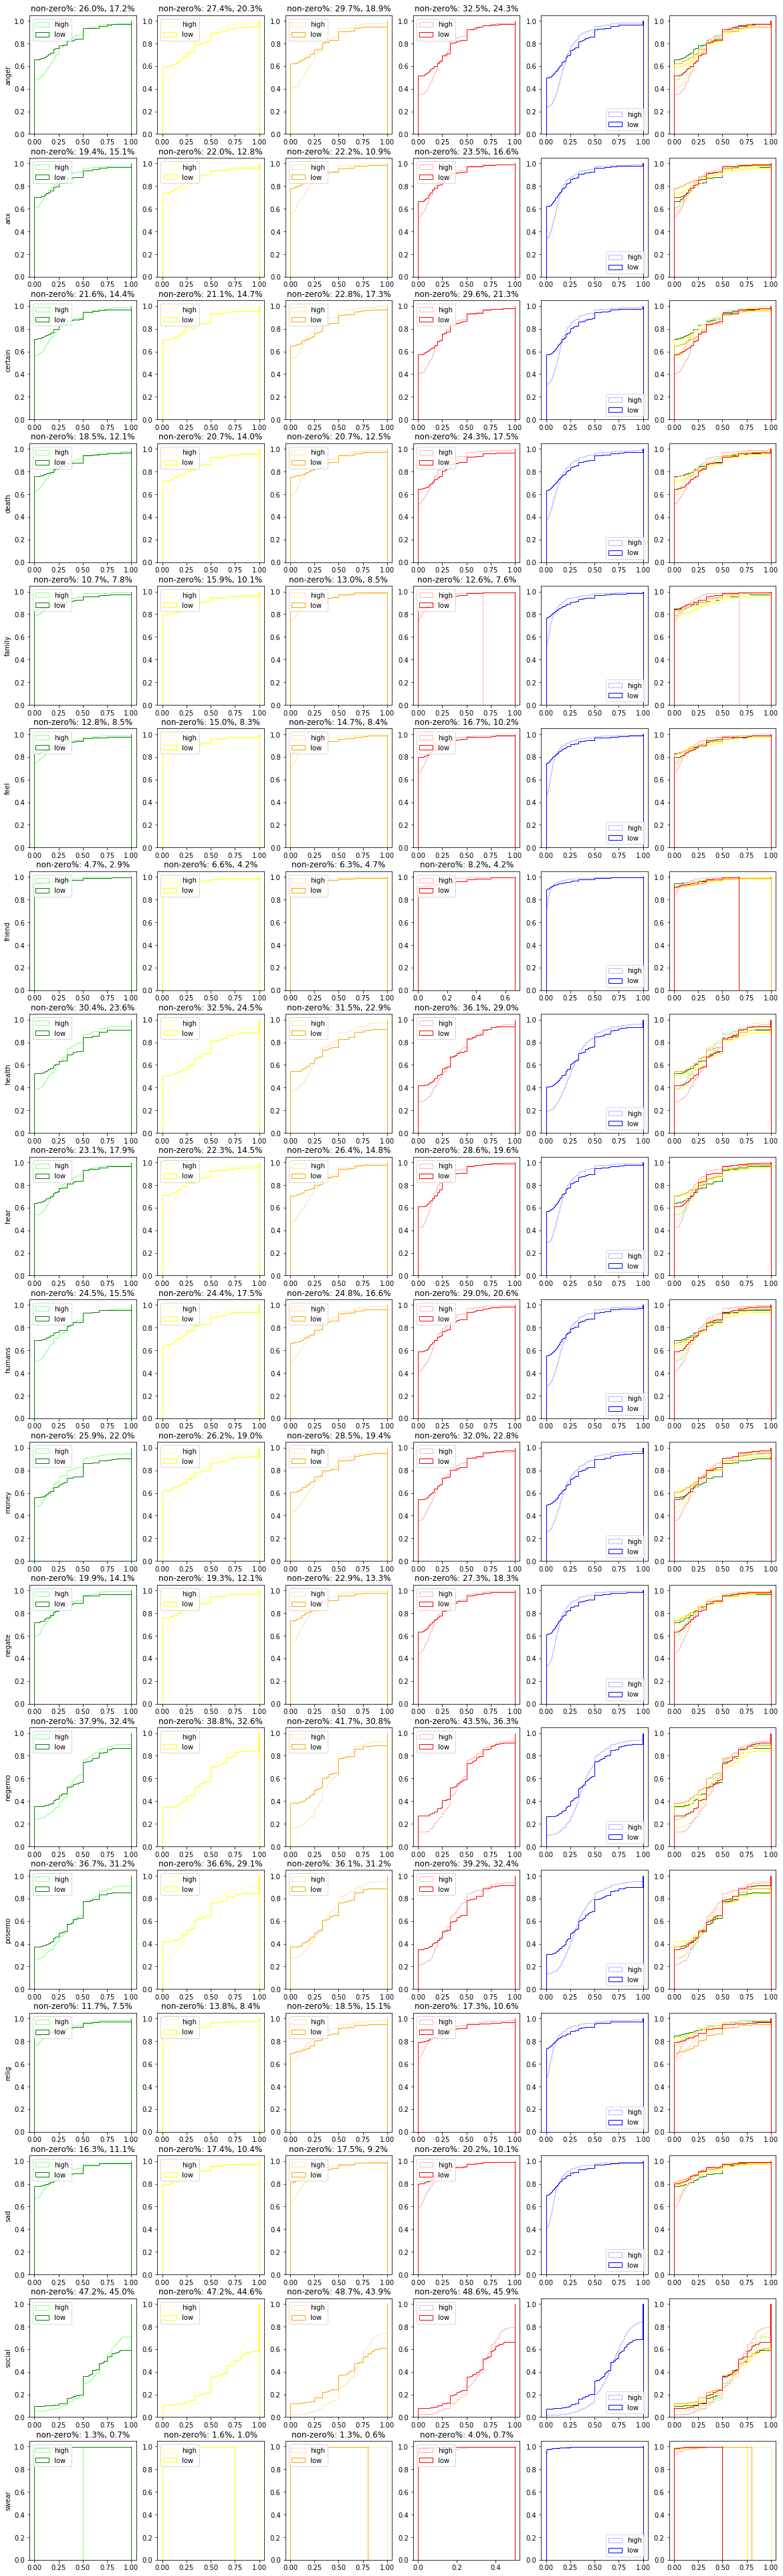

In [19]:
#LIWC by color - popularity

plot_df = all_nodes_df

cumulative = True

fig, ax = plt.subplots(len(candidates), 6, figsize=(20, 70))

# fig.suptitle("CDF of LIWC features Grouped by High/Low Popularities (blue represents all nodes)", fontsize="x-large")

for j, feat in enumerate(candidates):
    for i, color in enumerate(non_mix_COLORS):
        _color_data = plot_df[(plot_df['color'] == COLORS.index(color))]

        _pop = _color_data['pop']

        _high_data = _color_data[_color_data['pop'] >= np.median(_pop)][feat]
        _low_data = _color_data[_color_data['pop'] < np.median(_pop)][feat]
        
        
        ax[j][i].hist(_high_data, color=lighten_color(color, 0.3), density=True, bins=400, cumulative=cumulative, histtype='step', label='high')
        ax[j][i].hist(_low_data, color=lighten_color(color, 1.0), density=True, bins=400, cumulative=cumulative, histtype='step', label='low')

        ax[j][i].legend(loc='upper left')
        
        _high_length = len([item for item in _high_data if (item > 0 and item <= 1)])
        _low_length = len([item for item in _low_data if (item > 0 and item <= 1)])
        
        ax[j][i].set_title(f'non-zero%: {_high_length/len(_color_data)*100:.1f}%, {_low_length/len(_color_data)*100:.1f}%')

        ax[j][5].hist(_high_data, color=lighten_color(color, 0.3), density=True, bins=400, cumulative=cumulative, histtype='step', label='high')
        ax[j][5].hist(_low_data, color=lighten_color(color, 1.0), density=True, bins=400, cumulative=cumulative, histtype='step', label='low')
        

    
    _pop = plot_df['pop']
    _high_data = plot_df[plot_df['pop'] >= np.median(_pop)]
    _low_data = plot_df[plot_df['pop'] < np.median(_pop)]


    ax[j][4].hist(_high_data[feat], color=lighten_color('blue', 0.3), density=True, bins=400, cumulative=True, histtype='step', label='high')
    ax[j][4].hist(_low_data[feat], color=lighten_color('blue', 1.0), density=True, bins=400, cumulative=True, histtype='step', label='low')

    ax[j][4].legend(loc='lower right')
    ax[j][0].set_ylabel(feat)


plt.show()



note:  "non-zero%" is the percentage of (#high/low pop, having non-zero LIWC scores nodes) devided by #nodes of that color.


**feel, friendswear**: not many non-zero scores present. no significance can be observed.


On distributions:

In nearly all cases, LIWC features are conditional to values on popularity (in another word, without thresholding the LIWC feature values, it's in-sensitive to high/low popularity).

However, some of the features are sensitive to colors:

red/orange nodes are having less **positive emotion,  and social**, but more **certainty and religion**.

red/orange + high popularity nodes are having more **anxiety and anger**

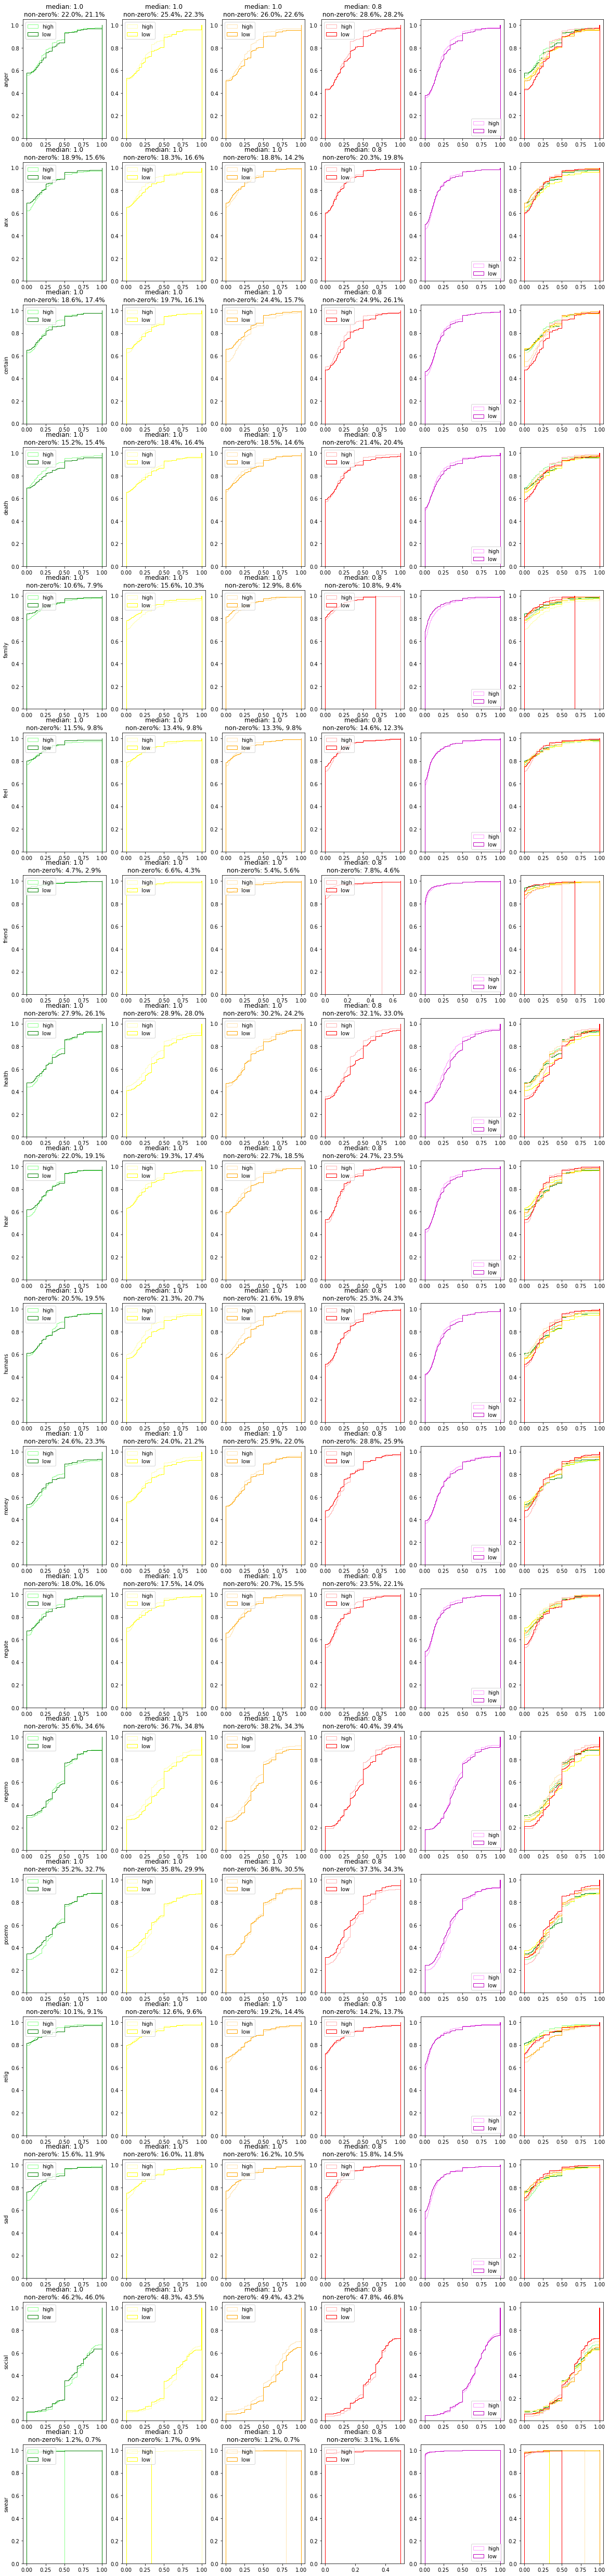

In [20]:
#LIWC by color - velocity

plot_df = all_nodes_df

velocity = 'velocity_ratio'
# velocity = 'lifespan'
# velocity = 'halflife'


scale = lambda x:x

cumulative = True

fig, ax = plt.subplots(len(candidates), 6, figsize=(20, 90))

# fig.suptitle("CDF of LIWC features Grouped by High/Low Popularities (blue represents all nodes)", fontsize="x-large")

for j, feat in enumerate(candidates):
    for i, color in enumerate(non_mix_COLORS):
        _color_data = plot_df[(plot_df['color'] == COLORS.index(color))]

        _pop = _color_data[velocity]
        
        _high_data = _color_data[_color_data[velocity] >= np.median(_pop)][feat]
        _low_data = _color_data[_color_data[velocity] < np.median(_pop)][feat]

        ax[j][i].hist(_high_data, color=lighten_color(color, 0.3), density=True, bins=400, cumulative=cumulative, histtype='step', label='high')
        ax[j][i].hist(_low_data, color=lighten_color(color, 1.0), density=True, bins=400, cumulative=cumulative, histtype='step', label='low')

        ax[j][i].legend(loc='upper left')

        
        _high_length = len([item for item in _high_data if (item > 0 and item <= 1)])
        _low_length = len([item for item in _low_data if (item > 0 and item <= 1)])
        
        ax[j][i].set_title(f'median: {np.median(_pop):.1f}\nnon-zero%: {_high_length/len(_color_data)*100:.1f}%, {_low_length/len(_color_data)*100:.1f}%')

        
        ax[j][5].hist(_high_data, color=lighten_color(color, 0.3), density=True, bins=400, cumulative=cumulative, histtype='step', label='high')
        ax[j][5].hist(_low_data, color=lighten_color(color, 1.0), density=True, bins=400, cumulative=cumulative, histtype='step', label='low')


    _pop = plot_df[velocity]
    _high_data = plot_df[plot_df[velocity] >= np.median(_pop)]
    _low_data = plot_df[plot_df[velocity] < np.median(_pop)]


    ax[j][4].hist(_high_data[feat], color=lighten_color('m', 0.3), density=True, bins=400, cumulative=True, histtype='step', label='high')
    ax[j][4].hist(_low_data[feat], color=lighten_color('m', 1.0), density=True, bins=400, cumulative=True, histtype='step', label='low')

    ax[j][4].legend(loc='lower right')
    ax[j][0].set_ylabel(feat)


plt.show()


Most of the features are not different in general on high/low velocity ratio.

However, in **anger, health, negate** the high velocity ratio tends to have lower value in these features,  
- **family, positive emotion** would make the propagation slower


# Q2-2: what are the LIWC patterns for story subjects over weeks? 

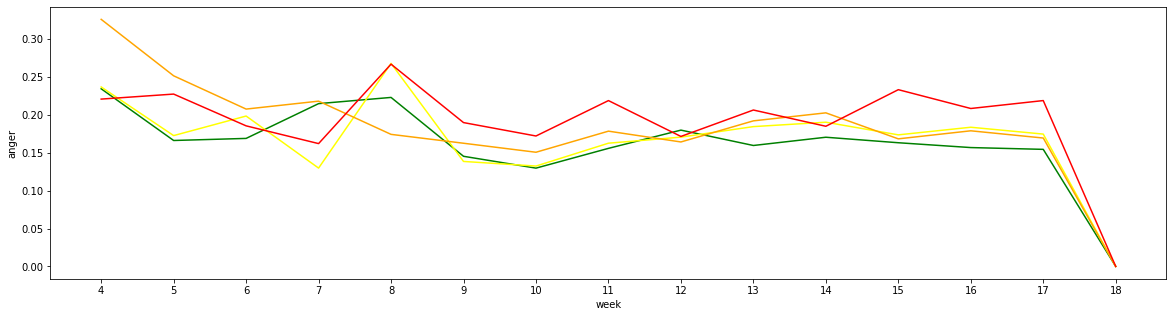

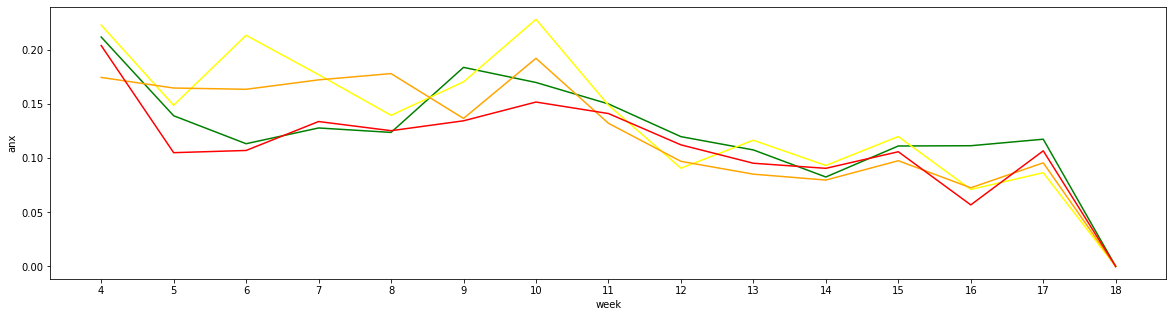

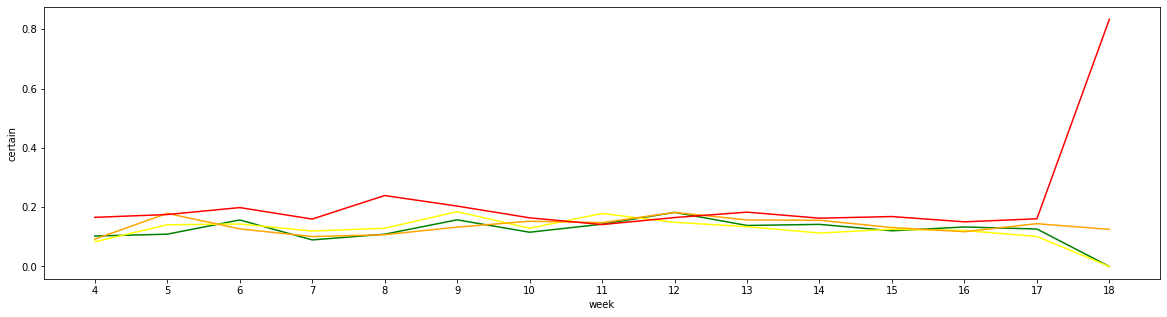

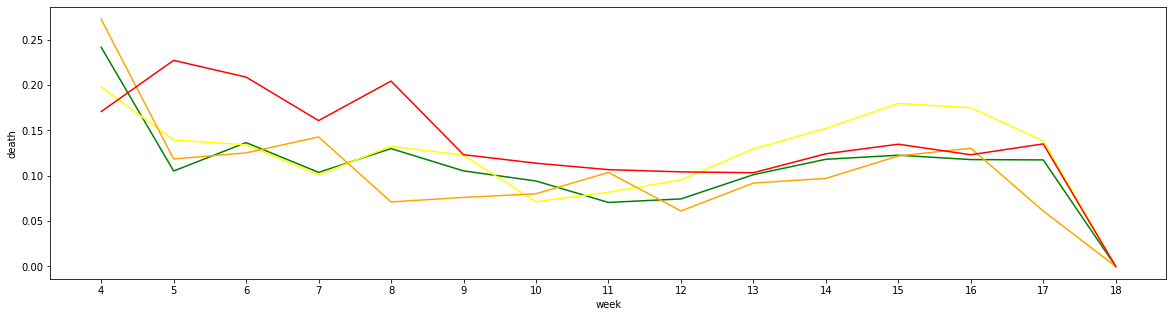

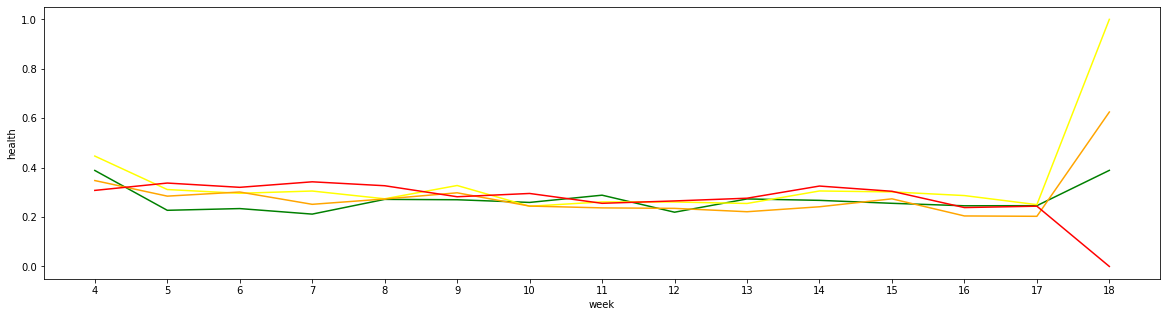

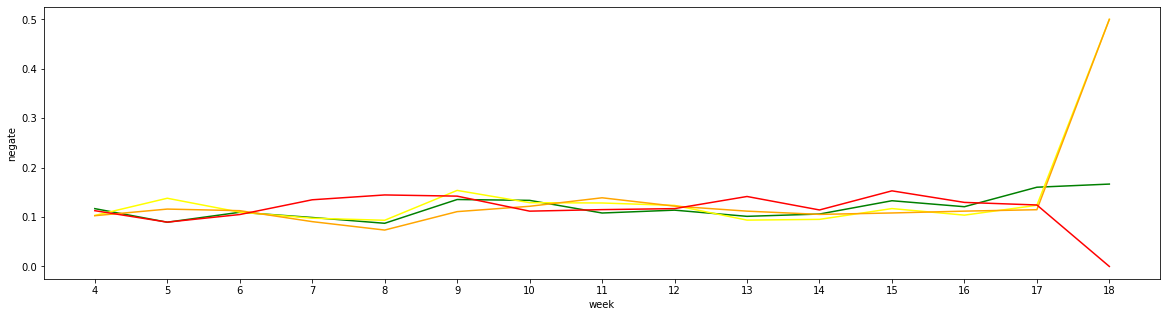

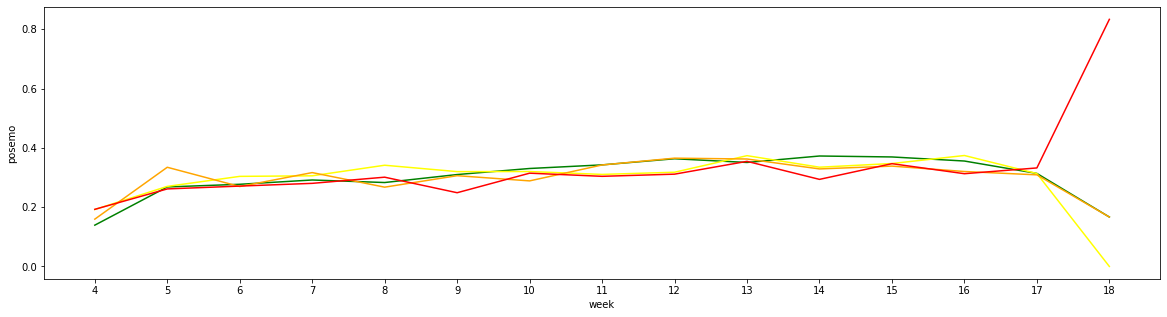

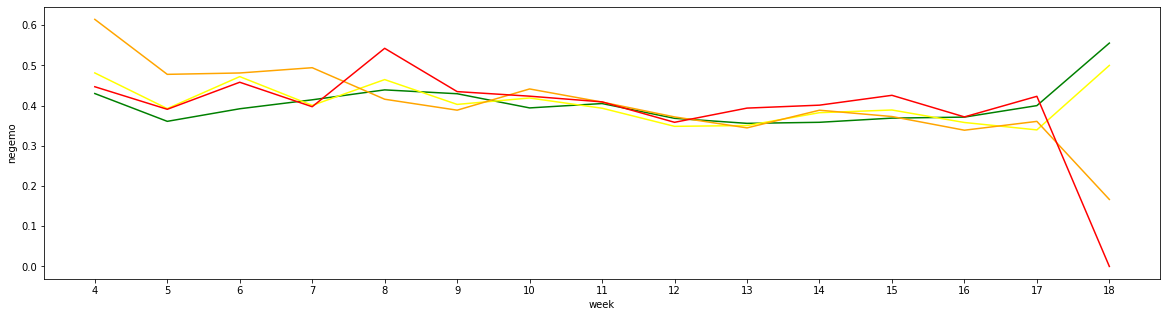

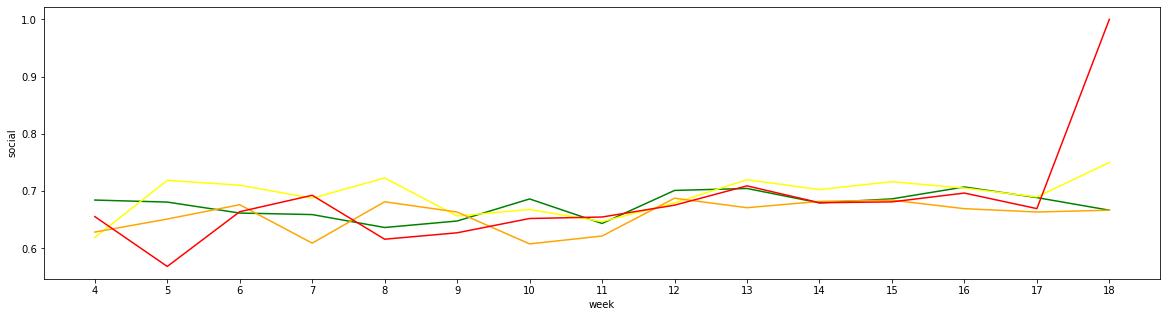

In [17]:
#LIWC -> weekly change


plot_df = weekly_nodes_df
selected_LIWC = ['anger', 'anx', 'certain', 'death', 'health', 'negate', 'posemo', 'negemo', 'social']


for feat in selected_LIWC:
    fig, ax = plt.subplots(1, 1, figsize=(20, 5))
    
    
    for color in non_mix_COLORS:
        
        weekly_data = []
        for week in WEEKS:
            _data = weekly_nodes_df[(weekly_nodes_df['color'] == COLORS.index(color)) & (weekly_nodes_df['week'] == week)][feat]
             
            weekly_data.append(np.mean(_data))
            
        ax.plot(weekly_data, color=color)
    
    ax.set_ylabel(f'{feat}')
    ax.get_xaxis().set_visible(True)
    ax.set_xticks(range(len(WEEKS)))
    ax.set_xticklabels([f'{item:.0f}' for item in WEEKS])
    ax.set_xlabel('week')
    
    plt.show()



# Q3-1: what are rumors (represent the span of a rumor in narrative graphs)?

## A case exploration for finalizing definitions: bioweapon-coronavirus at week 7

***Definition of a Rumor in Narrative Graph***: all actants/triplets appeared in the same article where the rumor actants appeared in.


***RQ3-1-1***: is the above definition making sense?

In [ ]:
inspect_week = 7

G, GD, nodes_in_graph, und_edges_in_graph, dir_edges_in_graph = pickle.load(open(f'output/graph_title+1s_week_{inspect_week}.pkl', 'rb'))

BY_WEEK_RELS, BY_WEEK_RAW = pickle.load(open(f'data/{"title+1s"}_by_week.pkl', 'rb'))


rumor_actants = ['bioweapon']
suspicious_posts = set([])

s_posts_edges = {}
suspicious_nodes = set([])
suspicious_edges = set([])
for ra in rumor_actants:
    for nb in G.neighbors(ra):
        if nb < ra:
            _edge_name = f'{nb}<->{ra}'
        else:
            _edge_name = f'{ra}<->{nb}'

        _edge_meta = und_edges_in_graph[_edge_name]
        _posts = set([])
        for verb in _edge_meta:
            _posts = _posts | verb['posts']

        suspicious_posts.update(_posts)                                     

for edge in G.edges:
    if edge[0] < edge[1]:
        edge_name = f'{edge[0]}<->{edge[1]}'
    else:
        edge_name = f'{edge[1]}<->{edge[0]}'
    
    for item in und_edges_in_graph[edge_name]:
        for post in item['posts']:
            if post in suspicious_posts:
                if post not in s_posts_edges:
                    s_posts_edges[post] = set([])
                s_posts_edges[post].add(edge)
                suspicious_edges.add(edge)
        
for post in s_posts_edges:
    for edge in s_posts_edges[post]:
        suspicious_nodes.add(edge[0])
        suspicious_nodes.add(edge[1])

## posts that created the edges of rumor:

In [ ]:
for post in s_posts_edges:
    art = BY_WEEK_RAW[inspect_week][post]
    print(f'Post title: {art["title"]}')
    print(f'Domain: {art["domain"]}')
    sent = art["text"].split(".\n")[0]
    print(f'First sent: {sent}')
    print()
    print('Edges:')
    for edge in s_posts_edges[post]:
        print(edge)
          
    print('----------------------------------------------------')
    print()

We can find that 3 of the areticles are copying the same sentence though with different titles. 

The materials are not only creating connected rumor components in the graph, but also disjoint relationships, for instance, "mainstream press", "brand", "notion".

The sub-graph of such component is as below:

In [ ]:
rumor = nx.Graph(G.subgraph(suspicious_nodes))

rumor_comp = max(nx.connected_components(rumor), key=len)
          
rumor = nx.Graph(G.subgraph(rumor_comp))


pos = nx.planar_layout(rumor)
for edge in rumor.edges():
    if (edge[0], edge[1]) not in suspicious_edges and (edge[1], edge[0]) not in suspicious_edges:
          rumor.remove_edge(edge[0], edge[1])

pos['SUPER:conspiracy_theory|idea'] -= np.array([0, 0.1])
nx.draw(rumor, pos=pos, with_labels = True)

It seems if keeping the major component in such sub-graphs, we can find the reasonble cluster representing the rumor's span over the full graph. To exam, I plot the same rumor on week 5 to validate:


Unlike the previous example, this time most of the nodes connect to each other. Yet with the largest component here, we still have a reasonable cluster of "bioweapon" rumor. Only a few words (i.e. breaking_news) is wrongly included.

# node prediction

In [ ]:
import numpy as np
from scipy.stats import norm
from sklearn.linear_model import LogisticRegression

def logit_pvalue(model, x):
    """ Calculate z-scores for scikit-learn LogisticRegression.
    parameters:
        model: fitted sklearn.linear_model.LogisticRegression with intercept and large C
        x:     matrix on which the model was fit
    This function uses asymtptics for maximum likelihood estimates.
    """
    p = model.predict_proba(x)
    n = len(p)
    m = len(model.coef_[0]) + 1
    coefs = np.concatenate([model.intercept_, model.coef_[0]])
    x_full = np.matrix(np.insert(np.array(x), 0, 1, axis = 1))
    ans = np.zeros((m, m))
    for i in range(n):
        ans = ans + np.dot(np.transpose(x_full[i, :]), x_full[i, :]) * p[i,1] * p[i, 0]
    vcov = np.linalg.inv(np.matrix(ans))
    se = np.sqrt(np.diag(vcov))
    t =  coefs/se  
    p = (1 - norm.cdf(abs(t))) * 2
    return p



In [ ]:
#transform non-probability features (e.g. LIWC features) into normal distribution by quantiles. 
#This spreads the over centralized values (e.g. in popularity) and provide robustness against extreme outliers
import copy

from sklearn.preprocessing import MinMaxScaler

quantile_transformer = preprocessing.QuantileTransformer(n_quantiles=10000, output_distribution='normal', random_state=42)
minmax = preprocessing.MinMaxScaler()

norm_data = minmax.fit_transform(quantile_transformer.fit_transform(all_nodes_df[all_nodes_df.columns[13:]])) #[13:] non-probability features


normalized_df = copy.deepcopy(all_nodes_df)


normalized_df[normalized_df.columns[13:]] = norm_data

normalized_df = normalized_df[normalized_df['color'] <= 3]

# normalized_df = normalized_df[normalized_df['velocity_ratio'] >= np.median(normalized_df['velocity_ratio'])]
normalized_df = normalized_df[normalized_df['pop'] >= np.median(normalized_df['pop'])]

# normalized_df = normalized_df[normalized_df['color'] == 0 | normalized_df['color'] == 3]


x = normalized_df[['connect_green', 'connect_yellow', 'connect_orange', 'connect_red', 'homophily', 
                   'freq', 'anger', 'anx', 'certain', 'death', 
                   'family', 'health', 'negate', 'negemo', 'posemo', 
                   'relig', 'sad', 'social',  'swear']]

# y_prop = normalized_df['pop']
# y_prop = normalized_df['velocity_ratio']
# y_bin = [1 if item >= np.median(y) else 0 for item in y]


y_color = normalized_df['color']
y_bin = [1 if item >= 2 else 0 for item in y_color]
